## Match extra genomes to closest leaves in the tree

The Tree of Life contains 10575 taxa. This script attempts to map the remaining 75625 genomes to the tree by assigning them to their closest taxa by MinHash distance.

Dependencies

In [145]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from skbio.tree import TreeNode
from skbio.stats.distance import DistanceMatrix

In [150]:
%matplotlib inline

Load distance matrix

In [2]:
dm = DistanceMatrix.read('prokaryotes.dm.bz2')
dm.shape[0]

86200

In [22]:
allg = dm.ids

In [5]:
with open('taxa.txt', 'r') as f:
    leaves = f.read().splitlines()
len(leaves)

10575

In [6]:
extras = set(dm.ids) - set(leaves)
len(extras)

75625

Get ID of the closest leaf and MinHash distances of top 10 closest leaves for each extra genome.

In [16]:
neighbors = {}
top10mashes = {}
for extra in sorted(extras):
    leaf2mash = pd.Series(dm[extra], index=allg).loc[leaves]
    for leaf, mash in leaf2mash.sort_values()[1:].iteritems():
        if extra not in neighbors:
            neighbors[extra] = leaf
            top10mashes[extra] = []
        top10mashes[extra].append(mash)
        if len(top10mashes[extra]) == 10:
            break

In [19]:
with open('summary.txt', 'w') as f:
    for g in sorted(extras):
        f.write('%s\n' % '\t'.join([g, neighbors[g]] + [str(x) for x in top10mashes[g]]))

Distribution of MinHash distance from closest leaf per extra genome

In [157]:
data = [v[0] for k, v in top10mashes.items()]

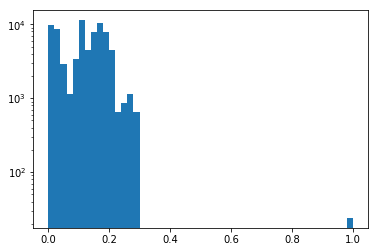

In [158]:
plt.hist(data, bins=50)
plt.yscale('log', nonposy='clip')

In [96]:
n = len([x for x in data if x < 0.3])
n

75601

In [98]:
print('%d (%.5f%%) extra genomes have closest MinHash distance < 0.3.' % (n, n / len(data)))

75601 (0.99968%) extra genomes have closest MinHash distance < 0.3.


Deal with genomes without neighbor (MinHash = 1.0).

In [102]:
len([x for x in data if x == 1.0])

24

In [106]:
nomatch = set([k for k, v in top10mashes.items() if v[0] == 1.0])
print(sorted(nomatch))

['G000190395', 'G000219195', 'G000220965', 'G000398105', 'G000485435', 'G000708735', 'G001129085', 'G001144025', 'G001144865', 'G001156845', 'G001199935', 'G001318645', 'G001319485', 'G001341675', 'G001345435', 'G001469435', 'G001508715', 'G001549365', 'G001549395', 'G001549515', 'G001563995', 'G001724075', 'G900010165', 'G900014395']


In [107]:
wmatch = extras - nomatch
len(wmatch)

75601

Distribution of number of closest extra genomes per leaf

In [20]:
leaf2extra = {}
for extra, leaf in neighbors.items():
    if leaf in leaf2extra:
        leaf2extra[leaf].add(extra)
    else:
        leaf2extra[leaf] = set([extra])
len(leaf2extra)

4724

In [75]:
print('Top 10 most neighbored leaves:')
i = 1
for leaf in sorted(leaf2extra, key=lambda x: len(leaf2extra[x]), reverse=True):
    print('\t'.join((str(len(leaf2extra[leaf])), leaf, names[leaf])))
    if i == 10:
        break
    i += 1

Top 10 most neighbored leaves:
7406	G000344275	Streptococcus oralis subsp. tigurinus AZ_3a
5153	G000340435	Mycobacterium haemophilum DSM 44634
3755	G000006925	Shigella flexneri 2a str. 301
2695	G000009865	Staphylococcus haemolyticus JCSC1435
1870	G001068545	Staphylococcus epidermidis
1798	G000191145	Acinetobacter pittii PHEA-2
1725	G000026345	Escherichia coli IAI39
1657	G000648515	Citrobacter freundii CFNIH1
1590	G000455385	Pseudomonas alcaligenes OT 69
994	G000247895	Raoultella ornithinolytica 10-5246


In [153]:
data = [len(v) for k, v in leaf2extra.items()]

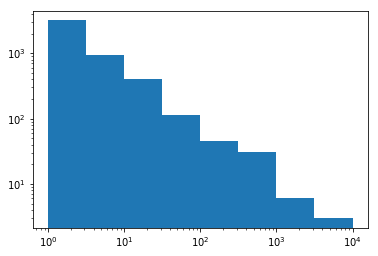

In [155]:
plt.hist(data, bins=np.logspace(np.log10(1),np.log10(10000), 9))
plt.gca().set_xscale('log')
plt.yscale('log', nonposy='clip')

Taxonomic analysis

In [53]:
with open('orgn_names.tsv', 'r') as f:
    names = dict(x.split('\t') for x in f.read().splitlines())
len(names)

86200

In [54]:
ranks = pd.read_table('rank_names.tsv', index_col=0, header=0)
ranks.shape[0]

86200

In [115]:
sames = {x: 0 for x in ranks.columns}
for g in sorted(wmatch):
    for rank in sames:
        if ranks[rank][g] == ranks[rank][neighbors[g]]:
            sames[rank] += 1

In [161]:
df = pd.DataFrame.from_dict(sames, orient='index')
df.reset_index(inplace=True)
df.columns = ['rank', 'number']
df['percentage'] = df['number'] / len(wmatch) * 100
df

,rank,number,percentage
0,kingdom,75418,99.757940
1,phylum,73769,97.576752
2,class,72583,96.007989
3,order,71383,94.420709
4,family,70796,93.644264
5,genus,60973,80.651050
6,species,13348,17.655851


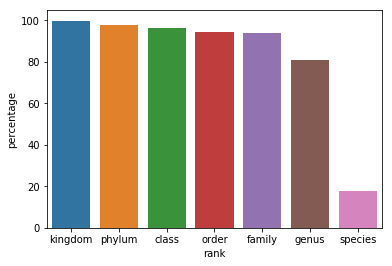

In [152]:
ax = sns.barplot(x='rank', y='percentage', data=df);

In [173]:
diff_spp = {}
for g in sorted(wmatch):
    if ranks['species'][g] != ranks['species'][neighbors[g]]:
        diff_spp[g] = ranks['species'][g]
print('%d genomes\' closest neighbors were assigned to different species.' % len(diff_spp))

62253 genomes' closest neighbors were assigned to different species.


In [174]:
sp_counts = ranks['species'].value_counts().to_dict()

In [175]:
n = 0 
for g, sp in diff_spp.items():
    if sp_counts[sp] == 1:
        n += 1
print('%d of them were so because the current species is the only representative in the '
      'dataset.' % n)

10847 of them were so because the current species is the only representative in the dataset.


Add extra genomes into tree as multifurcating leaves from their closest leaf.

In [188]:
tree = TreeNode.read('astral.MR.rooted.nid.nwk')
tree.count(tips=True)

10575

In [189]:
for leaf, extras in leaf2extra.items():
    tree.find(leaf).parent.extend([TreeNode(x) for x in extras if x not in nomatch])
tree.count(tips=True)

86176

In [190]:
# hard-coded: N2 is Archaea, tree.childrenia
print(tree.children[0].name, tree.children[1].name)

1:N2 0.75:N3


In [191]:
for g in nomatch:
    if ranks['kingdom'][g] == 'Archaea':
        tree.children[0].extend([TreeNode(g)])
    elif ranks['kingdom'][g] == 'Bacteria':
        tree.children[1].extend([TreeNode(g)])
tree.count(tips=True)

86200

In [192]:
tree.write('full.nwk')

'full.nwk'